<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/total_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seeing the imperceptible: total flow

this is a notebook which is used to have a set of images move through the processing steps which can individually be found in the topic related folders.

A **batch** of images will be processed and all intermediate steps will be saved. This is not an optimized flow, yet a flow allowing the user to intervene where necessary and have updated images continue throughout the flow.

This flow is created to test with some experts and capture their feedback, it is not intended for day-to-day usage. One testing day will be organized in which this notebook will be used with some unique images.

## steps

1. Sensor dust removal
2. Image Editing (LaMa)
3. Background Removal
4. Background Recoloring: not yet
5. Clothes recoloring: not yet
6. Skin retouching
<!-- 7. Face Detection -->
7. optional: Color Corrections: not yet
8. Color Grading: 
9. Image upscaling

TODO: is it necessary to create a config file and have separate notebooks for each step? (with 1 common config generator)

In [2]:
# first we'll link a database connection:
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py --silent
from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

what's the username for nextcloud? colab
what's the password for user colab? ··········
0
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  


## SETUP

we'll link this instance of the machine learning flow to your name:

In [3]:
tname = 'total' #@param {type:"string"}
if(tname=='total'):
    print("Are you sure you don't want to change the name?")

Are you sure you don't want to change the name?


## Step 1: Sensor dust removal

we'll link the main input folder and write the output images in the output folder of step 1.

In [4]:
#@title imports of libraries & setting up
input_step1, output_step1 = create_io(database=nextcloud,topic=tname,library='step1_sensor_dust', input_redirect='/content/database/total/input')

#import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os, sys
!curl https://raw.githubusercontent.com/Tschucker/Python-Automatic-Sensor-Dust-Removal/main/shapedetector.py -o /content/shapedetector.py
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from shapedetector import ShapeDetector
import imutils
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1255  100  1255    0     0   9160      0 --:--:-- --:--:-- --:--:--  9160


In [5]:
#@title Set inpainting options and run the model
radius = 11 #@param {type:"slider",min:1, max:50}
flags = cv2.INPAINT_TELEA #@param ["cv2.INPAINT_TELEA","cv2.INPAINT_NS"]

def inpaint_img(img_path, img_name, output_path, radius=10, flags=cv2.INPAINT_TELEA):
  #color version
  cimg = cv2.imread(img_path)
  #grey scale image
  img = cv2.imread(img_path,0)

  #Apply Global Threshold
  m = np.mean(img, dtype=int)
  global_thresh = cv2.threshold(img,int(m/1.2),255,cv2.THRESH_BINARY_INV)[1]

  #Perform Adaptive Threshold
  adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,10)

  #Image Magnification Filter Kernel
  KERNEL = np.ones((10,10), dtype=int)*10

  #Filter the thresholded images*
  img_filt = cv2.filter2D(adaptive_thresh_img,-1,KERNEL)
  #global_thresh = cv2.filter2D(global_thresh,-1,KERNEL)

  #Apply multiple times
  for i in range(2):
      KERNEL_i = np.ones((int(10),int(10)), dtype=int)*10
      img_filt = cv2.filter2D(img_filt,-1,KERNEL_i)

  #Combine Thresholds
  comb = img_filt + global_thresh

  #Find and Classify Contours of Image
  cnts = cv2.findContours(comb.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  sd = ShapeDetector()
  cimg_copy = cimg.copy()
  for c in cnts:
      # compute the center of the contour, then detect the name of the
      # shape using only the contour
      M = cv2.moments(c)
      if M["m00"] != 0:
          cX = int((M["m10"] / M["m00"]) * 1)
          cY = int((M["m01"] / M["m00"]) * 1)
          shape = sd.detect(c)
          # multiply the contour (x, y)-coordinates by the resize ratio,
          # then draw the contours and the name of the shape on the image
          if len(c) < 50:
              c = c.astype("float")
              c *= 1
              c = c.astype("int")
              cv2.drawContours(cimg_copy, [c], -1, (0, 255, 0), 2)
              cv2.putText(cimg_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)
  
  #Create Dust Mask
  img_mask = np.zeros((img.shape[0], img.shape[1]), dtype='uint8')
  for c in cnts:
      # compute the center of the contour, then detect the name of the
      # shape using only the contour
      M = cv2.moments(c)
      if M["m00"] != 0:
          cX = int((M["m10"] / M["m00"]) * 1)
          cY = int((M["m01"] / M["m00"]) * 1)
          shape = sd.detect(c)
          # multiply the contour (x, y)-coordinates by the resize ratio,
          # then draw the contours and the name of the shape on the image
          if len(c) < 50:
              c = c.astype("float")
              c *= 1
              c = c.astype("int")
              cv2.fillPoly(img_mask, pts=[c], color=(255,255,255))

    
  #Inpaint the image
  cimg_inpaint = cv2.inpaint(cimg, img_mask, radius, flags=flags)

  #Show and Save Final Image
  save_img_pth = os.path.join(output_path,img_name)
  cv2.imwrite(save_img_pth, cimg_inpaint)

  # plt_out = cv2.cvtColor(cimg_inpaint, cv2.COLOR_BGR2RGB)
  # return plt_out

for img_name in os.listdir(input_step1):
  print("processing ",img_name)
  img_path = os.path.join(input_step1,img_name)
  inpaint_img(img_path, img_name, output_step1, radius=radius, flags=flags)

processing  1.jpg
processing  2.jpg


### verification

Now it's time to go to the database and verify the results. If needed we adapt the images locally. 

TODO: how easily can we **sync** the images to allow the experts to intervene? Is it possible with nextcloud?

## step 2: Minor retouching: image editing LaMa 
Once verified we want to continue with the next step, being image editing (LaMa model)

therefore we link the output folder of previous step to the inputfolder of this step.

In [6]:
#@title imports of libraries & setting up

input_step2, output_step2 = create_io(database=nextcloud,topic=tname,library='step2_lama', input_redirect=output_step1)
root_path2 = '/content/lama'

# clone the repository
if not os.path.exists(root_path2):
  !git clone https://github.com/saic-mdal/lama {root_path2}
# Set up the environment
print('\n> Install dependencies')
!pip install -q -r lama/requirements.txt 
!pip install torchtext==0.9.0 --quiet 
!pip install torchvision==0.9.0 --quiet 
!pip install -q wget 

# download the model
print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o {root_path2}/big-lama.zip
# todo check where the model is unzipped
!unzip {root_path2}/big-lama.zip -d {root_path2}
# fixing openCV
print('>fixing opencv')
!pip uninstall -q opencv-python-headless -y 
!pip install -q opencv-python-headless==4.1.2.30 

Cloning into '/content/lama'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 313 (delta 50), reused 44 (delta 40), pack-reused 239
Receiving objects: 100% (313/313), 9.85 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (91/91), done.

> Install dependencies
     |████████████████████████████████| 12.5 MB 5.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 72 kB 463 kB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
     |████████████████████████████████| 841 kB 44.1 MB/s 
     |████████████████████████████████| 271 kB 44.1 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 948 kB 40.3 MB/s 
     |████████████████████████████████| 47.8 MB 67 kB/s 
     |████████████████████████████████| 112 kB 52.9 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |█

In [7]:
#@title imports & helper functions

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


In [8]:
step2_temp = '/content/database/total/step2temp'
os.makedirs(step2_temp,exist_ok=True)
for i in os.listdir(input_step2):
  shutil.copy2(os.path.join(input_step2,i),step2_temp)

/content/lama
Will use 1 from /content/database/total/step2temp/1.jpg for inpainting


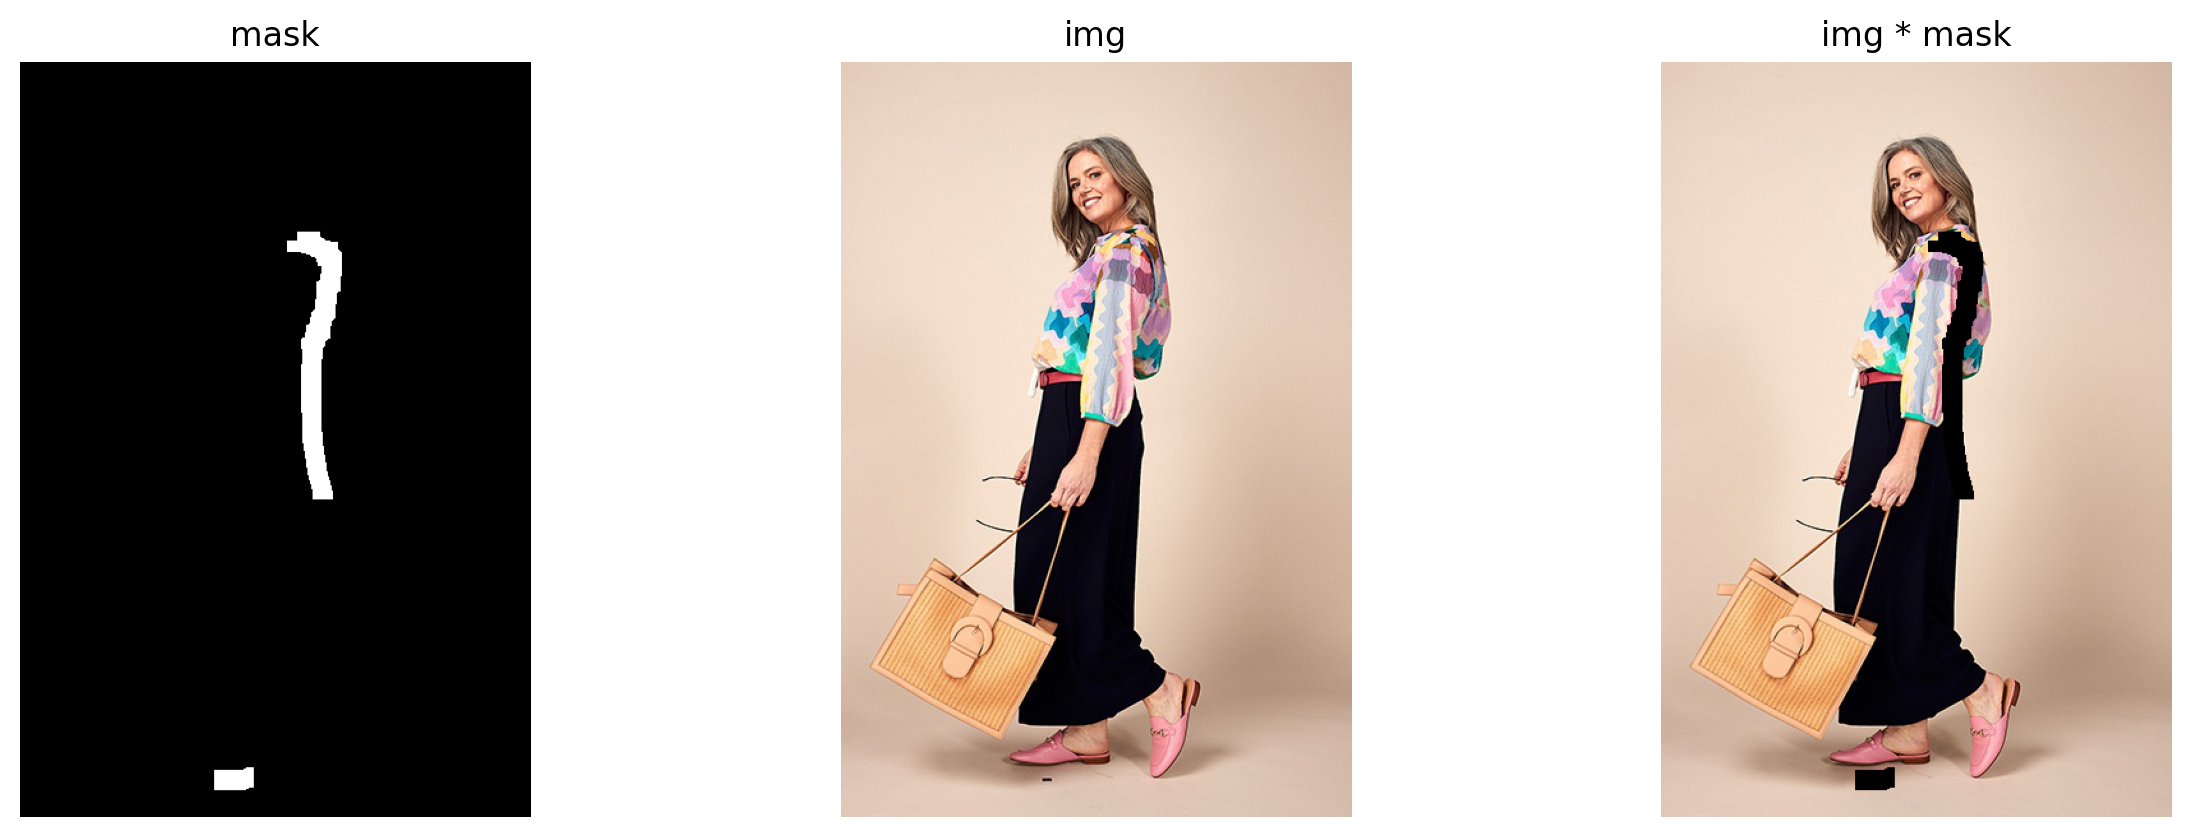

Will use 2 from /content/database/total/step2temp/2.jpg for inpainting


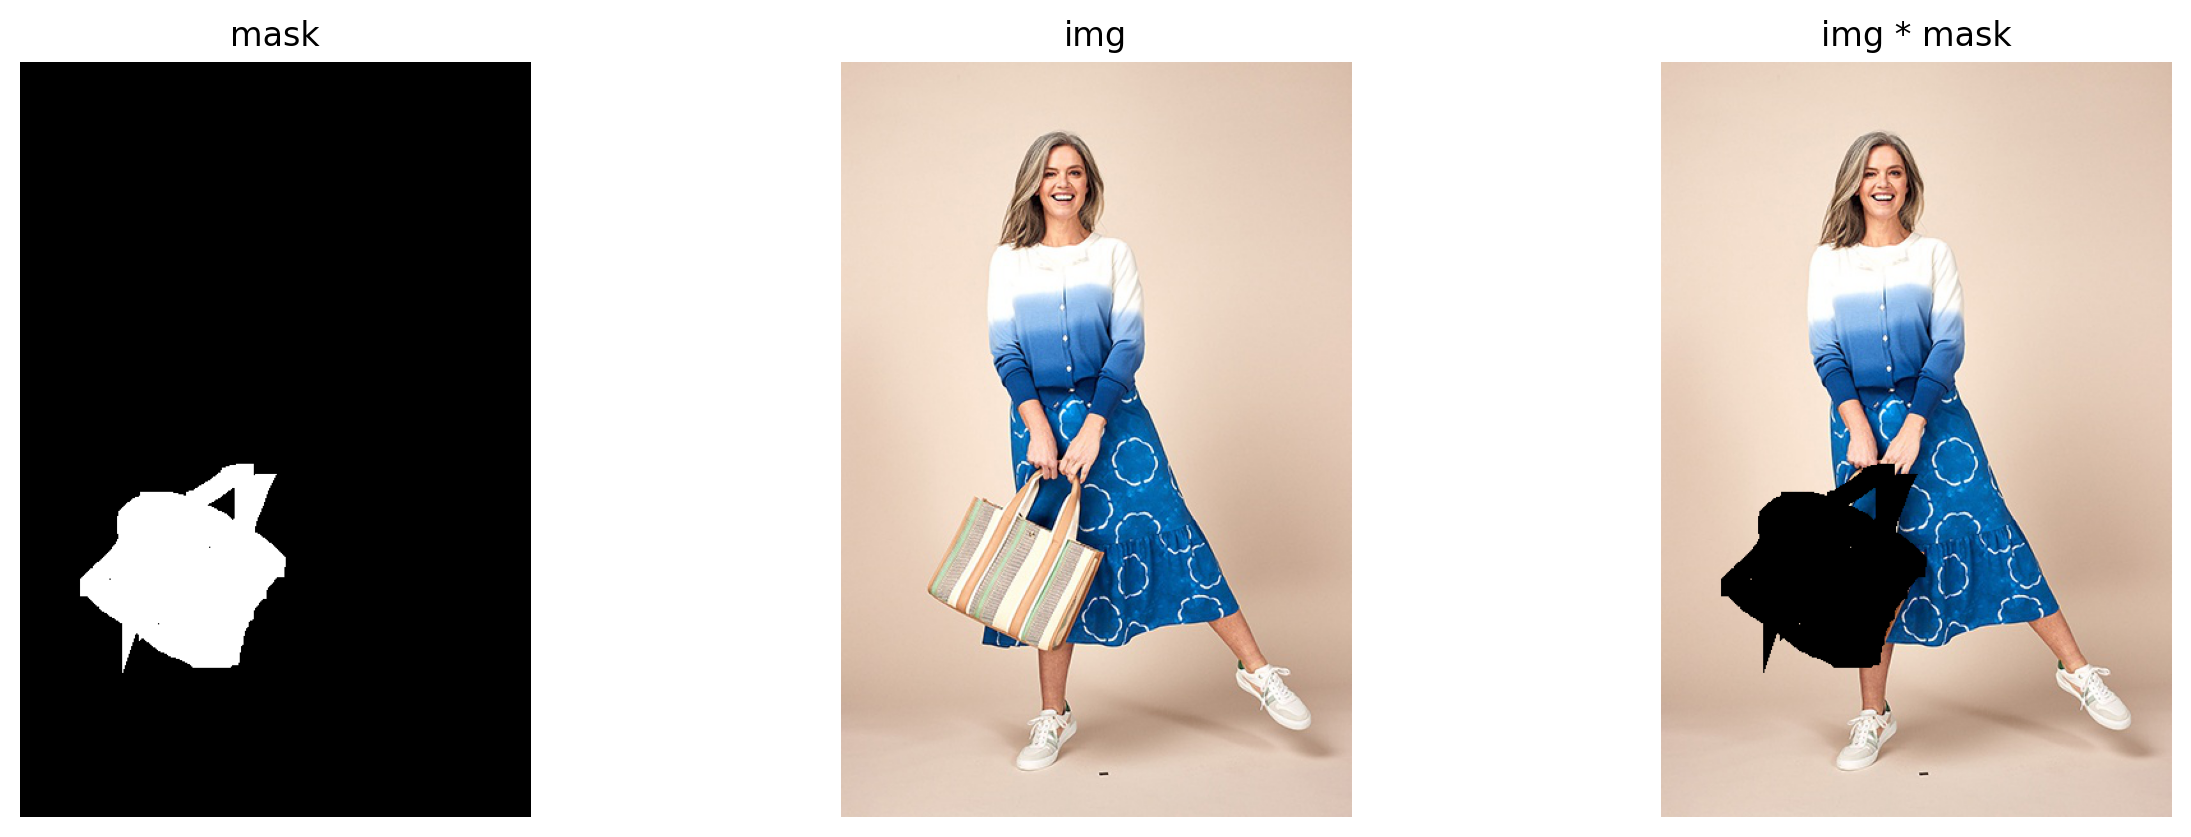

100% 2/2 [00:05<00:00,  2.81s/it]


In [9]:
%cd {root_path2}
#todo still need to fix the layout of the button
#@title Minor Retouching via LaMa
for i in os.listdir(step2_temp):
  if('mask' in i):
    # fix if we run the cell multiple times, not to take into account the masks
    continue
  fpath = os.path.join(step2_temp,i)

  image64 = base64.b64encode(open(fpath, 'rb').read())
  image64 = image64.decode('utf-8')
  fname = fpath.split('/')[-1].split('.')[0]
  print(f'Will use {fname} from {fpath} for inpainting')
  img = np.array(plt.imread(f'{fpath}')[:,:,:3])

  draw(image64, filename=f"./{fname}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
  
  import matplotlib.pyplot as plt
  plt.rcParams["figure.figsize"] = (15,5)
  plt.rcParams['figure.dpi'] = 200
  plt.subplot(131)
  with_mask = np.array(plt.imread(f"./{fname}_mask.png")[:,:,:3])
  mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
  plt.imshow(mask, cmap='gray')
  plt.axis('off')
  plt.title('mask')
  plt.imsave(f"{step2_temp}/{fname}_mask.png",mask, cmap='gray')

  plt.subplot(132)
  img = np.array(plt.imread(f'{fpath}')[:,:,:3])
  plt.imshow(img)
  plt.axis('off')
  plt.title('img')

  plt.subplot(133)
  img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fpath)[:,:,:3])
  _=plt.imshow(img)
  _=plt.axis('off')
  _=plt.title('img * mask')
  plt.show()

if '.jpeg' in fpath:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py  model.path=$(pwd)/big-lama indir={step2_temp}  outdir={output_step2}  dataset.img_suffix=.jpeg   > /dev/null
elif '.jpg' in fpath:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py  model.path=$(pwd)/big-lama indir={step2_temp}  outdir={output_step2}  dataset.img_suffix=.jpg    > /dev/null
elif '.png' in fpath:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py  model.path=$(pwd)/big-lama indir={step2_temp}  outdir={output_step2}  dataset.img_suffix=.png    > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200

for i in (os.listdir(output_step2)):
  i_name = i.replace('_mask','')
  os.rename(os.path.join(output_step2,i),os.path.join(output_step2,i_name))

## Step 3: background removal

Again, verify the outcome of step 2. 

Now we'll subtract the background using the PaddleSeg model



In [10]:
#@title
input_step3, output_step3 = create_io(database=nextcloud,topic=tname,library='step3_bg_removal', input_redirect=output_step2)

In [11]:
#@title imports for paddleseg
!pip install -q PaddlePaddle
root_path = '/content/PaddleSeg'

# clone the repository
if not os.path.exists(root_path):
  !git clone https://github.com/PaddlePaddle/PaddleSeg {root_path}

%cd {root_path}
!pip -qq install -r requirements.txt'
!pip install -e .

# installing Matting
%cd Matting
!pip -qq install -r requirements.txt

     |████████████████████████████████| 112.3 MB 8.7 kB/s 
     |████████████████████████████████| 236 kB 45.2 MB/s 
Cloning into '/content/PaddleSeg'...
remote: Enumerating objects: 17650, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 17650 (delta 57), reused 94 (delta 37), pack-reused 17518
Receiving objects: 100% (17650/17650), 341.83 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (11279/11279), done.
/content/PaddleSeg
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file
Obtaining file:///content/PaddleSeg
     |████████████████████████████████| 2.7 MB 5.3 MB/s 
     |████████████████████████████████| 199 kB 34.8 MB/s 
     |████████████████████████████████| 2.1 MB 33.8 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 127 kB 45.9 MB/s 
     |████████████████████████████████| 69 kB 7.5

In [12]:
#@title downloading the models
# download model checkpoint 
model_path = root_path + '/Matting/data/model'
model_params = 'https://paddleseg.bj.bcebos.com/matting/models/human_matting-resnet34_vd.pdparams'
model_inf = 'https://paddleseg.bj.bcebos.com/matting/models/deploy/pp-humanmatting-resnet34_vd.zip'
# make folders
os.makedirs(model_path, exist_ok=True)
if not os.path.exists(os.path.join(model_path,'human_matting.pdparams')):
  print('\n> Download the model params')
  !curl {model_params} -o {os.path.join(model_path,'human_matting.pdparams')}
else:
  print ('\n> File already downloaded')
if not os.path.exists(os.path.join(model_path,'human_matting-resnet.zip')):
  print('\n> Download the model')
  !curl {model_inf} -o {os.path.join(model_path,'human_matting-resnet.zip')}
  !unzip -q {os.path.join(model_path,'human_matting-resnet.zip')} -d {os.path.join(model_path)}
else:
  print ('\n> File already downloaded')


> Download the model params
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  243M  100  243M    0     0  4456k      0  0:00:56  0:00:56 --:--:-- 6438k

> Download the model
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  226M  100  226M    0     0  6003k      0  0:00:38  0:00:38 --:--:-- 10.5M


In [17]:
mode = 'background_replacement' #@param ['background_removal','background_replacement']
step3_temp = '{}/total/step3temp'.format(nextcloud)
os.makedirs(step3_temp, exist_ok=True)
if(mode=='background_removal'):
# predict
  !export CUDA_VISIBLE_DEVICES=0
  !python predict.py \
      --config configs/human_matting/human_matting-resnet34_vd.yml \
      --model_path data/model/human_matting.pdparams \
      --image_path {input_step3} \
      --save_dir {step3_temp} \
      --fg_estimate True
else:
  # bg replacement
  #TODO right now all images get the same background image
  #@markdown either choose an rgbw value as background or type the path to the bgimage:
  background = 'b' #@param ['r','g','b','w'] {allow-input: true}
  !export CUDA_VISIBLE_DEVICES=0
  for infer_img in os.listdir(input_step3):
    !python bg_replace.py \
        --config configs/human_matting/human_matting-resnet34_vd.yml \
        --model_path data/model/human_matting.pdparams \
        --image_path {os.path.join(input_step3,infer_img)} \
        --save_dir {step3_temp} \
        --background {background} \
        --fg_estimate True
for i in os.listdir(step3_temp):
  if('_' in i):
    #we only want to copy the output files to the next step
    continue
  shutil.copy2(os.path.join(step3_temp,i),os.path.join(output_step3,i))

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

## Step 4: Clothes recoloring

In [18]:
input_step4, output_step4 = create_io(database=nextcloud,topic=tname,library='step4_clothes_coloring', input_redirect=output_step3)

In [19]:
import shutil
# as we're not implementing clothes recoloring yet, we copy the folders to surpass this step
for file in os.listdir(input_step4):
  shutil.copy2(os.path.join(input_step4, file), output_step4)

## Step 5: Skin retouching

we'll implement the retouchML library

In [20]:
input_step5, output_step5 = create_io(database=nextcloud,topic=tname,library='step5_skin_retouch', input_redirect=output_step4)

In [23]:
#@title
!pip install 'h5py==2.10.0' #--force-reinstall
# numpy versions from 1.20 throw an error further down the road, might need to restart the runtime.
!pip install numpy==1.19.5
root_path5 = '/content/retouchML'
# clone the repository
if not os.path.exists('retouchML'):
  !git clone https://github.com/ju-leon/RetouchML {root_path5}

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Cloning into '/content/retouchML'...
remote: Enumerating objects: 290, done.
remote: Total 290 (delta 0), reused 0 (delta 0), pack-reused 290
Receiving objects: 100% (290/290), 81.87 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (122/122), done.
1.15.2


In [24]:
#@title we first create the 'improved' images of faces
%cd {root_path5}
# make folders
!mkdir aligned_images alignement_vector

!python align_images.py {input_step5} aligned_images/ alignement_vector/

!python encode_images.py aligned_images/ generated_images/ latent_representations/ \
    --vgg_url=https://rolux.org/media/stylegan/vgg16_zhang_perceptual.pkl \
    --lr=0.4 \
    --iterations=200 \
    --use_best_loss=True \
    --early_stopping=True \
    --load_resnet=True \
    --composite_blur=6 # default=8
for i in os.listdir(os.path.join(root_path5,'generated_images')):
  shutil.copy2(os.path.join(root_path5,'generated_images',i),os.path.join(output_step5,i))

/content/retouchML
Using TensorFlow backend.
64045056/64040097 [==============================] - 1s 0us/step
Using TensorFlow backend.
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
58892288/58889256 [==============================] - 1s 0us/step
  0% 0/2 [00:00<?, ?it/s]Rects:
rectangles[[(46, 64) (201, 219)]]
Saving mask masks/1_01.png
Loading mask masks/1_01.png

  0% 0/200 [00:00<?, ?it/s]
1_01: loss 303.7218; lr 0.4000:   0% 0/200 [00:15<?, ?it/s]
1_01: loss 303.7218; lr 0.4000:   0% 1/200 [00:16<53:31, 16.14s/it]
1_01: loss 281.2327; lr 0.4000:   0% 1/200 [00:17<53:31, 16.14s/it]
1_01: loss 281.2327; lr 0.4000:   1% 2/200 [00:17<23:55,  7.25s/it]
1_01: loss 259.4839; lr 0.4000:   1% 2/200 [00:18<23:55,  7.25s/it]
1_01: loss 259.4839; lr 0.4000:   2% 3/200 [00:18<14:27,  4.40s/it]
1_01: loss 234.8039; lr 0.4000:   2% 3/200 [00:19<14:27,  4

In [31]:
#@title then we stitch them back together with their original image
face_path = "generated_images/" 
mask_path = "masks/"
vector_path = "alignement_vector/"
for i in os.listdir(input_step5):
  img_name = i
  raw_path = os.path.join(input_step5,img_name)
  out_path = os.path.join(output_step5, img_name)

  !python fit_faces.py $raw_path $face_path $mask_path $vector_path $out_path

Using TensorFlow backend.
Done!
Using TensorFlow backend.
Done!


## Step 6: Color Corrections

[Curl]()



In [25]:
input_step6, output_step6 = create_io(database=nextcloud,topic=tname,library='step6_color_corrections', input_redirect=output_step5)

## Step 7: Color Grading

Model: deep preset

In [ ]:
input_step7, output_step7 = create_io(database=nextcloud,topic=tname,library='step7_color_grading', input_redirect=output_step6)

## Step 8: image upscaling

Model: RealESRGan

[ESRGan](https://github.com/luca-arts/seeingtheimperceptible/blob/main/notebooks/basicSuperRestoration/tests/Real_ESRGAN.ipynb)


In [ ]:
input_step8, output_step8 = create_io(database=nextcloud,topic=tname,library='step8_image_upscaling', input_redirect=output_step7)